# Contract machine

In [1]:
# References: 
# Algebraic Dynamics: https://github.com/AlgebraicJulia/AlgebraicDynamics.jl/blob/master/src/dwd_dynam.jl
# Catlab: https://github.com/AlgebraicJulia/Catlab.jl/blob/master/src/wiring_diagrams/Directed.jl
# Interval sets: https://github.com/JuliaMath/IntervalSets.jl

In [2]:
using AlgebraicDynamics.DWDDynam
using Catlab.WiringDiagrams
using Catlab.Graphics
using Catlab.Graphics.Graphviz
using DifferentialEquations
using Plots
#-------
using IntervalSets  # Library is required to create intervals of real numbers
using PrettyTables
using LabelledArrays

In [3]:
# Add machine type module
include("ContractMachine.jl")
#using .StaticContractMachine

Main.StaticContractMachine

### 1. Composite contract

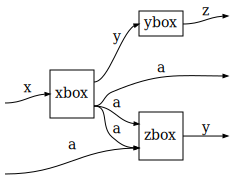

In [4]:
system = WiringDiagram([:x, :a], [:z, :a, :y])

xbox = add_box!(system, Box(:xbox, [:x], [:y, :a]))
ybox = add_box!(system, Box(:ybox, [:y], [:z]))
zbox = add_box!(system, Box(:zbox, [:a, :a], [:y]))

add_wires!(system, [  
    (input_id(system),1) => (xbox,1),  
    (input_id(system),2) => (zbox,2), 
    (xbox,1) => (ybox,1),
    (xbox,2) => (zbox,1),
    (xbox,2) => (zbox,2),
    (ybox,1) => (output_id(system),1),
    (zbox,1) => (output_id(system),3),
    (xbox,2) => (output_id(system),2)
])

to_graphviz(system, orientation=LeftToRight, labels=true)

In [5]:
xbox = StaticContractMachine.ContractMachine{Float64}( [-1.0..2.0], 2, [-2.0..4.0, -1..4.0], 
                                                (u,x,p,t) -> x .- u,
                                                (u,p,t) -> u * p.x)

ybox = StaticContractMachine.ContractMachine{Float64}( [-2.0..5.0], 1, [-5.0..2.0], 
                                                (u,x,p,t) -> x.-u,
                                                (u,p,t) -> u * p.y)
    
zbox = StaticContractMachine.ContractMachine{Float64}( [-3.0..6.0, -2.0..2.0], 1, [-Inf..Inf], 
                                                (u,x,p,t)-> sum(x) .- u, 
                                                (u,p,t) -> u * p.z)

StaticContract( [-3.0,6.0] × [-2.0,2.0] × ℝ )

In [6]:
net = StaticContractMachine.oapply(system, [xbox, ybox, zbox])

StaticContract( [-1.0,2.0] × [-2.0,2.0] × [-5.0,2.0] × ℝ × [-1.0,4.0] )

In [7]:
# inputs
param = (x=1, y=1, z=1)
us = [1,2,3,4]
xs = LVector(x=1, a=2)

# evaluate contracts
net.fcontract( us, xs, param )

box,input,output
directory,wire: contract,wire: contract
ybox,y : true,z : false
zbox,a : truea : false,y : true
xbox,x : true,y : truea : true


In [8]:
xbox.fcontract( [1,2], [1], param )

input,output
port: contract,port: contract
1 : true,1 : true2 : true


---
#### Nested System

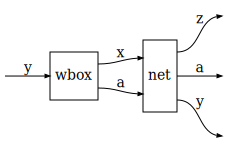

In [9]:
system2 = WiringDiagram([:y], [:z, :a, :y])

netbox = add_box!(system2, Box(:net, [:x, :a], [:z, :a, :y]))
wbox = add_box!(system2, Box(:wbox, [:y], [:x, :a]))

add_wires!(system2, [  
    (input_id(system2),1) => (wbox,1),  
    (wbox,1) => (netbox,1),
    (wbox,2) => (netbox,2),
    (netbox,1) => (output_id(system2),1),
    (netbox,2) => (output_id(system2),2),
    (netbox,3) => (output_id(system2),3)
])

to_graphviz(system2, orientation=LeftToRight, labels=true)

In [10]:
wbox = StaticContractMachine.ContractMachine{Float64}( [-10.0..10.0], 2, [-5.0..5.0, -15.0..15.0], 
                                                (u,x,p,t) -> x.-u,
                                                (u,p,t) -> u)

StaticContract( [-10.0,10.0] × [-5.0,5.0] × [-15.0,15.0] )

In [11]:
net2 = StaticContractMachine.oapply(system2, [net, wbox])

StaticContract( [-10.0,10.0] × [-5.0,2.0] × ℝ × [-1.0,4.0] )

In [12]:
# inputs
param = (x=1, y=1, z=1)
us = [1,2,3,4,5,6]
xs = LVector(y=1)

# evaluate
net2.fcontract(us, xs, param)

box,input,output
directory,wire: contract,wire: contract
:net => :xbox,x : false,y : truea : true
:net => :ybox,y : true,z : false
wbox,y : true,x : truea : true
:net => :zbox,a : truea : false,y : true


### 2. Check ODE solution with contracts

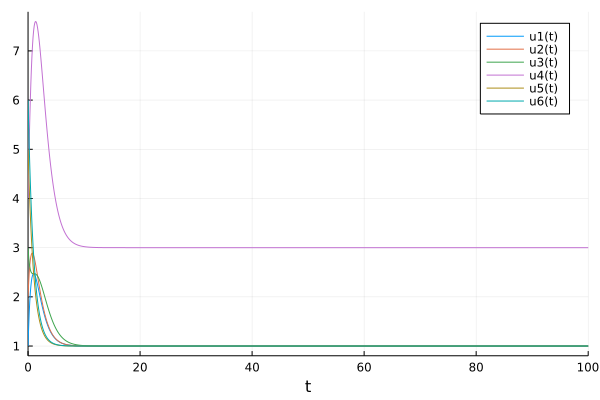

In [13]:
# inputs
param = (x=1, y=1, z=1)
us = [1,2,3,4,5,6]
xs = LVector(y=1)
time = (0, 100)

# evaluate
prob = StaticContractMachine.ODEProblem( net2, us, xs, time, param)

# Solve and plot
sol = solve(prob, alg_hints=[:stiff])
plot(sol)

In [14]:
dict = StaticContractMachine.check_contract(sol, net2, xs, param, out_type="time")

box,input,output
directory,wire: failure interval,wire: failure interval
:net => :xbox,"x : 0.000000 , 1.175557",
:net => :ybox,,"z : 0.000000 , 2.761824"
wbox,,
:net => :zbox,"a : 0.000000 , 100.000000",
